# Delft3D (D3D) IO Module

The following example will familiarize the user with using the d3d toolbox in MHKiT-Python. `d3d` can be used to plot the data from a NetCDF output from Delft3D [SNL-D3D-CEC-FM](https://github.com/MHKiT-Software/MHKiT-Python). The example will walk through a flume case with a turbine. The flume is 18 m long and 4 m wide with the turbine placed at 6 m along the length and 3 m along the width. The turbine used for this simulation has a circular cross-section with a diameter of 0.7m, a thrust coefficient of 0.72, and a power coefficient of 0.45. The simulation was run with 5 depth layers and 3-time intervals.

This example will show how to create a centerline plot at a desired depth for different variables outputs of Delft3D using matplotlib. It will also show how to make a contour plot of a given plane or depth for the variable output by Delft3D and how to use those variables to calculate turbulence intensity. This module can be helpful to visualize the wake of a turbine and help predict how a turbine will affect the surrounding area. 

Start by importing the necessary python packages and MHKiT module.  

In [1]:
from os.path import abspath, dirname, join, normpath, relpath
from mhkit.river.io import d3d 
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4

## Loading Data from Delft3D as a NetCDF 

 A NetCDF file has been saved in the [\\MHKiT-Python\\examples\\data\\river\\d3d](https://github.com/browniea/MHKiT-Python/tree/d3d/examples/data/river/d3d) directory of a simple flume case with a turbine for refrence data. Here we are inputting strings file path `datadir`, and file name `filename` so the NetCDF file can be saved as a NetCDF object using the python pack `netCDF4` under the variable  `d3d_data`.    
 
There are many variables saved in the NetCDF object `d3d_data`. The function `d3d_data.variables.keys()` returns a dictionary of the avalible data. Here we look at the dictionary keys output to see all the variables we can plot. 

In [2]:
datadir = normpath(join(relpath(join('data', 'river', 'd3d'))))
filename= 'turbineTest_map.nc'
d3d_data = netCDF4.Dataset(join(datadir,filename)) 

for var in d3d_data.variables.keys():
    try: 
        d3d_data[var].long_name
    except:
        print(f'"{var}"')        
    else:
        print(f'"{var}": {d3d_data[var].long_name}')

"mesh2d_enc_x": x-coordinate
"mesh2d_enc_y": y-coordinate
"mesh2d_enc_node_count": count of coordinates in each instance geometry
"mesh2d_enc_part_node_count": count of nodes in each geometry part
"mesh2d_enc_interior_ring": type of each geometry part
"mesh2d_enclosure_container"
"Mesh2D"
"NetNode_x": x-coordinate
"NetNode_y": y-coordinate
"projected_coordinate_system"
"NetNode_z": bed level at net nodes (flow element corners)
"NetLink": link between two netnodes
"NetLinkType": type of netlink
"NetElemNode": mapping from net cell to net nodes (counterclockwise)
"NetElemLink": mapping from net cell to its net links (counterclockwise)
"NetLinkContour_x": list of x-contour points of momentum control volume surrounding each net/flow link
"NetLinkContour_y": list of y-contour points of momentum control volume surrounding each net/flow link
"NetLink_xu": x-coordinate of net link center (velocity point)
"NetLink_yu": y-coordinate of net link center (velocity point)
"BndLink": netlinks that co

## Dataframe from NetCDF
First the variables to be pulled from the NetCDF file are defined and saved under the name `variable`. The variable `'ucx'` is velocity in the x-direction. (see advalible data in previos block output). The `d3d` function `get_all_data_points` will pull all the raw data from the NetCDF file for the specified variable at a specific time index in a dataframe `var_data_df`. The `time_index` can be used to pull data from a different instance in time. The first index is 0 and the user can use -1 to select the last time_index in the data set. The defalt `time_index` is set to -1.The last `time_index` can also be found by finding array dimension of the input variable, as shown the max valid value for `time_index` is output. 

In [3]:
variable= 'ucx' 

max_time_index= len(d3d_data.variables[variable][:])

print(f'max time_index:{max_time_index}')

# All data in  NetCDF File
var_data_df= d3d.get_all_data_points(d3d_data, variable, time_index=-1)

max time_index:2


## Plotting a Line Plot Between Two Centerline Points
To veiw the maximum effects of the tubine we will creat a aray down the center of our flume. We will then interpolate the grided data results onto our centerline array. 

For this line plot we will find the centerline of the flume. The centerline points are found by taking the average of the maximum and minimum value for the width, `y`, and height, `z`, of the flume. We will use The function `create_points` to create our centerline array to interpolate over with the input of one array, `x`, and two points, `y` and `z`. `create_points` will then  output a dataframe, `cline_points`, with keys `'x'`, `'y'`,and `'z'`, of points. 

In [4]:
xmin=var_data_df.x.max()
xmax=var_data_df.x.min()

ymin=var_data_df.y.max()
ymax=var_data_df.y.min()

zmin=var_data_df.z.max()
zmax=var_data_df.z.min()

x = np.linspace(xmin, xmax, num=100)
y = np.mean([ymin,ymax])
z = np.mean([zmin,zmax])

cline_points = d3d.create_points(x, y, z)

Next the variable `ucx` is interpolated over the `cline_points` using sipy interp function, and saved as `cline_variable`. The results are then plotted for  velocity in the x direction, `ucx`, along the length of the flume, `x`.

Text(0.5, 1.0, 'Centerline velocity on flow element center, x-component')

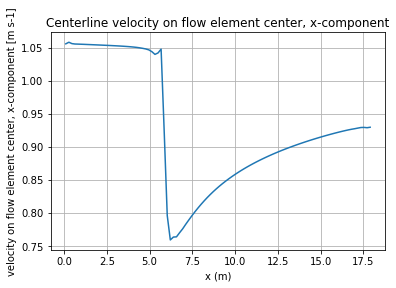

In [5]:
cline_variable = interp.griddata(var_data_df[['x','y','z']], 
                     var_data_df[variable],
                     cline_points[['x','y','z']])

Type='Centerline'
plt.plot(x, cline_variable)
plt.grid()
plt.xlabel('x (m)')
plt.ylabel(f'{d3d_data.variables[variable].long_name} [{d3d_data.variables[variable].units}]')
plt.title(f'{Type} {d3d_data.variables[variable].long_name}')

## Contour Plot for a Given Sigma Layer 

Sometimes it will be useful to plot only the raw data. Using `get_layer_data` a single layer of raw data will be retrieved from the NetCDF object. The `d3d` function ,`get_layer_data` takes 3 inputs, the netCDFobject (`d3d_data`), the vaiable name (`variable`) as a string, and the the layer to retrieve (`layer`) as an integer. The variable is set to the velocity in the x direction, `'ucx'`, and the layer of data to plot as 2. Since there are 5 sigma layers in this example layer 2 is approximatly the middle layer.  `layer`  works as an idex that begins at begins at 0 and ends at 4.  The `get_layer_data` then outputs a dataframe `layer_data` with the keys `'x'`, `'y'`, and '`v`' as the length, width, and value of the specified variable in this case velocity in the x direction, 'ucx'.  

To plot the data the maximum and minimum, "max_plot_v" and "min_plot_v", values are defined to limit bounds of the color bar to show the value of the specified variable, in this case it's velocity in the x direction. The type of plot is also defined as 'contour' to add to the title of the plot.

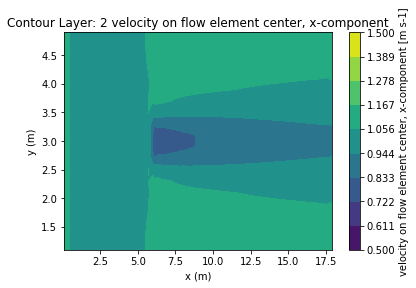

In [6]:
variable= 'ucx'
layer= 2
layer_data = d3d.get_layer_data(d3d_data, variable, layer)

max_plot_v= 1.5
min_plot_v=.5
  
Type= 'Contour'
plt.figure()
contour_plot = plt.tricontourf(layer_data.x ,layer_data.y, layer_data.v, vmin=min_plot_v,vmax=max_plot_v,
                               levels=np.linspace(min_plot_v,max_plot_v,10))
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(f'{Type} Layer: {layer} {d3d_data.variables[variable].long_name}')
cbar= plt.colorbar(contour_plot)
cbar.set_label(f'{d3d_data.variables[variable].long_name} [{d3d_data.variables[variable].units}]')

## Plotting a Contour Plot layer 

If you wanted to look at a contour plot of a specific depth you can create a contour plot over given points. Expanding on the centerline plot points we can create an array along the width of the flume, `y_contour` to add to the array along the length of the flume, `x`, and the point for the depth we want to look at `z`.  `create_points` then outputs a dataframe '`contour_points`' of points to calculate the contour values over with the keys `'x'`, `'y'`,and `'z'`.

In [7]:
x = np.linspace(xmin, xmax, num=100)
y_contour = np.linspace(ymin, ymax, num=40)
z = np.mean([zmin,zmax])

contour_points = d3d.create_points(x, y_contour, z) 

Next the data is interpolated on to the points created saved under the variable name `'contour_variable'`. 

In [8]:
contour_variable = interp.griddata(var_data_df[['x','y','z']], 
                                                     var_data_df[variable],
                                                     contour_points[['x','y','z']])

The results are then plotted. The minimum and maximum values show on the graph are defined by "max_plot_v" and "min_plot_v" as used in the previous example. The contour plot of the velocity is then output at the center depth of the flume. 

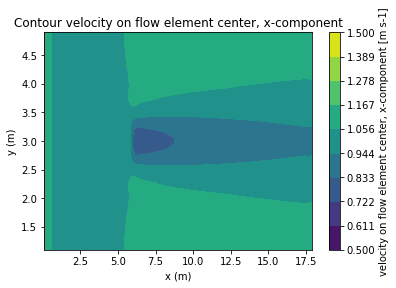

In [9]:
max_plot_v= 1.5
min_plot_v=.5

#Plot contour
Type= 'Contour'
plt.figure()
contour_plot = plt.tricontourf(contour_points.x,contour_points.y,contour_variable,
                               vmin=min_plot_v,vmax=max_plot_v,levels=np.linspace(min_plot_v,max_plot_v,10))
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(f'{Type} {d3d_data.variables[variable].long_name}')
cbar= plt.colorbar(contour_plot)
cbar.set_label(f'{d3d_data.variables[variable].long_name} [{d3d_data.variables[variable].units}]')

## Contour Plot of Turbulent Intensity 
Turbulent Intensity is the ratio of the magnitude of turbulent velocity to total velocity. The function `turbulent_intensity`  pulls variables 'ucx', 'ucy', 'ucz', and 'turkin1' as the velocity in the x, y, z and turbulence respetivly. The function then calculates and outputs the turbulent intensity, `turbulent_intensity`, for any given time_index in the data_frame `TI`. The `TI` dataframe also includes the `'x'`,`'y'`, and '`z'` location, turbulent kinetic energy `'turkin1'`, and velocity in the `'ucx'`, `'ucy'`, and `'ucz'` direction. In this example it is calculating the turbulent intensity over the same contour_points used above, however it can also calculate over 'cells', the coordinate system for the raw velocity data, or 'faces', the coordinate system for the raw turbulence data. If nothing is specified for 'points', 'cells' is the defalt coordiante system.    

Following the same format as the previous two contour plots the limits of the maximum and minimum value are defined by user as well as a string for the type of plot. The code then outputs a contour plot of the turbulent intensity.

points provided


,x,y,z,turkin1,ucx,ucy,ucz,turbulent_intensity
0,17.900000,4.9,1.001491,0.004836,1.063070,2.870343e-04,-0.011936,0.053406
1,17.720202,4.9,1.001491,0.004813,1.061810,2.725819e-04,0.128914,0.052960
2,17.540404,4.9,1.001491,0.004755,1.059829,2.484254e-04,0.018144,0.053115
3,17.360606,4.9,1.001491,0.004694,1.060141,2.231364e-04,-0.011759,0.052766
4,17.180808,4.9,1.001491,0.004705,1.060299,1.963520e-04,-0.002357,0.052822
...,...,...,...,...,...,...,...,...
3995,0.819192,1.1,1.001491,0.003562,1.055308,-5.733043e-07,-0.000745,0.046179
3996,0.639394,1.1,1.001491,0.003546,1.055458,-4.095826e-07,0.001553,0.046067
3997,0.459596,1.1,1.001491,0.003550,1.056048,-2.810840e-07,0.007136,0.046069
3998,0.279798,1.1,1.001491,0.003514,1.058133,-1.737856e-07,-0.009406,0.045741


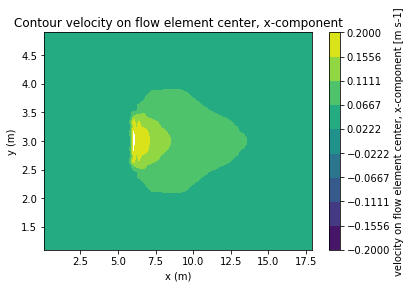

In [10]:
TI= d3d.turbulent_intensity(d3d_data, contour_points)

max_plot_v= 0.2
min_plot_v=-0.2

Type= 'Contour'
plt.figure()
contour_plot = plt.tricontourf(contour_points.x, contour_points.y, TI.turbulent_intensity,
                               vmin=min_plot_v, vmax=max_plot_v,levels=np.linspace(min_plot_v,max_plot_v,10))
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(f'{Type} {d3d_data.variables[variable].long_name}')
cbar= plt.colorbar(contour_plot)
cbar.set_label(f'{d3d_data.variables[variable].long_name} [{d3d_data.variables[variable].units}]')

TI

## Comparing two Face Data to Cell Data 
In Delft3d ther is a stager where some vaiables are stored on the faces and some are stored on the cells and this function allows you to interpolate the date on the faces to the ce3ll locations or vis viersa.  
Similar to the `turbulent_intensity` function shown above the `grid data` function is used to interpolate data sets on to the same grid. This is useful for camparing variables such as velocity and turbulence where the raw data points are not on the same.  For this example, we input the variable names, 'ucx' and 'turkin1', the NetCDF object, 'd3d_data', and the corrdinate system  'faces'. The output is an array, ` Var`, with the interpolated data. The data can be called as shown with ‘Var.’ followed by the variable name.   

#claculate Turbulent intensity, 

In [11]:
variables= ['ucx', 'turkin1']

Var= d3d.grid_data(d3d_data, variables, points= 'faces')

Var

,x,y,z,ucx,turkin1
0,0.1,1.1,0.199488,0.719636,0.011769
1,0.3,1.1,0.200017,0.694261,0.012186
2,0.1,1.3,0.199488,0.719636,0.012374
3,0.5,1.1,0.200070,0.700325,0.012030
4,0.3,1.3,0.200017,0.694261,0.012186
...,...,...,...,...,...
8995,17.7,4.7,1.795276,1.234666,0.001459
8996,17.5,4.9,1.795364,1.214983,0.001035
8997,17.9,4.7,1.800533,1.251318,0.001467
8998,17.7,4.9,1.795273,1.234800,0.001246
